In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from DataLoader.my_dataloader import get_loader
from DCNN.model import Model_sep, Model, Ensemble
import torch
import torch.nn as nn
from data.prepare_data import get_data_paths, read_CT_scans, missing_PTVs, read_data, read_all_data, delete_duplication, read_masks
import sklearn.metrics
import os
import seaborn as sns


In [2]:
model_name = '' #AUTO, DCNN, DCNN_2ENC
bottleneck = '' #None, Vit, DFA


PATH = 'Output/DCNN_Vit_None_ROI_LOSS/best_val_evaluation_uloss.pkl'
PATH1 = 'Output/DCNN_2ENC_None_ROI_SM_LOSS/best_val_evaluation_uloss.pkl'
PATH2 = 'Output/DCNN_2ENC_None_L1LOSS/best_val_evaluation_uloss.pkl'

PATH_OUT = 'Output/DCNN_2ENC_None_L1LOSS/output_6LOSS'
if not os.path.exists(PATH_OUT):
    os.mkdir(PATH_OUT)

train, val, test = get_loader('data', train_bs=32,
        val_bs=1,
        test_bs=1,
        train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
        val_num_samples_per_epoch=1200,
        test_num_samples_per_epoch=1200,
        num_works=1,
        resplit=False,
        seed=199,#199
        with_miss_PTVs=True,
        with_distance=True
    )



### Data Visualization

In [3]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(data, predicted=None):
    CT_scan = data[0][0,2]
    PTVs = data[0][0,0]
    OARs = data[0][0,1]
    Rdose = data[1][0,0]
    distance_image = data[0][0,3]
    if predicted is None: a=5 
    else: a=7
    fig, axs = plt.subplots(ncols=a, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap='gray')

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap='jet')

    axs[0, 2].set_title("Distance transform")
    axs[0, 2].imshow(distance_image, cmap='jet')

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs, cmap='jet')

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap='jet')

    

    if predicted is not None:
        axs[0, 5].set_title("predicted Radiation dose")
        axs[0, 5].imshow(predicted, cmap='jet')

        axs[0, 6].set_title("Difference")
        axs[0, 6].imshow(np.abs(predicted - Rdose), cmap='jet')
    plt.show()



In [ ]:
for batch_idx, list_loader_output in enumerate(val):
    show(list_loader_output[0]['data'])
    if batch_idx==10: break

### Data Duplication

In [58]:
import os
def condition(b):
    return 'sample' in b and ('val' in b)
train_val = [a[0] for a in os.walk('data/') if condition(a[0])]

In [59]:
d = read_all_data(train_val)

reading all the data


1200it [00:08, 136.58it/s]


In [ ]:
samples, indices = np.unique(d, axis=0, return_index=True)

In [ ]:
samples.shape

(7124, 5, 128, 128)

In [ ]:
#delete_duplication(train_val) 

reading all the data


9000it [01:12, 124.85it/s]


Find unique samples
Deleting duplicated sampeles
1876 duplicated samples found


100%|██████████| 1876/1876 [00:02<00:00, 657.03it/s]


### Missing PTVs

In [ ]:
data_paths = get_data_paths(dir)
missing_indices = missing_PTVs(data_paths, which_set='train', indices=False)
len(missing_indices)

10200it [00:13, 736.04it/s] 


648

In [ ]:
for p in missing_indices:
    if 'test' not in p:
        continue
    dict = read_data(p)
    CT_scan = dict[2]
    PTVs = dict[0]
    OARs = dict[1]
    Rdose = dict[-1]
    mask = dict[3]>0
    fig, axs = plt.subplots(ncols=5, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap='gray')
    #axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap='jet')

    axs[0, 2].set_title("possible dose mask")
    axs[0, 2].imshow(mask, cmap='gray')

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs[0], cmap='jet')

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap='jet')
    plt.show()
    

In [ ]:
def custom_distance(a,b):
    mask = np.logical_or(a>0,b>0)
    return np.mean(np.abs(a[mask] - b[mask]))

In [ ]:
data_paths = get_data_paths(dir)
CTs = read_CT_scans(val.dataset.list_case_id)
missing_indices = missing_PTVs(data_paths, in_test=True)

mask = np.ones(CTs.shape[0], dtype=bool)
mask[missing_indices] = False
missing_CTs = CTs[missing_indices]
non_Missing_CTs = CTs[mask]
pairwise_distance = sklearn.metrics.pairwise_distances(missing_CTs.reshape(missing_CTs.shape[0], -1),
                                                    non_Missing_CTs.reshape(non_Missing_CTs.shape[0], -1),
                                                    metric=custom_distance)
closest_CTs = pairwise_distance.argmin(axis=1)

10200it [00:09, 1055.60it/s]
10200it [00:03, 2989.89it/s]


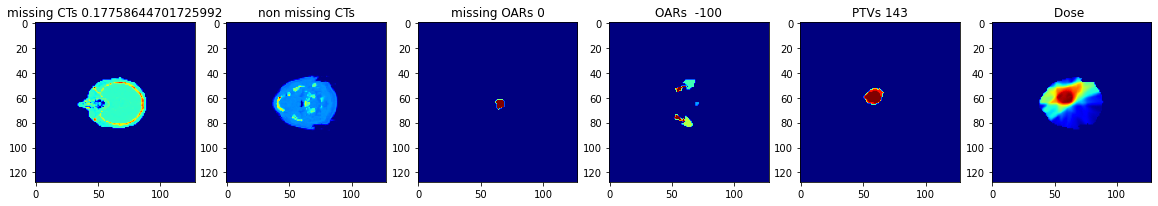

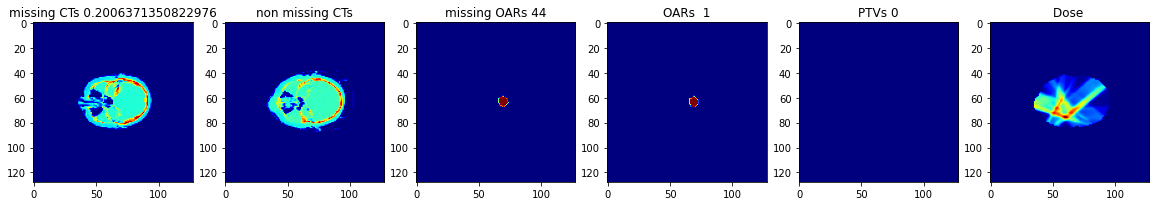

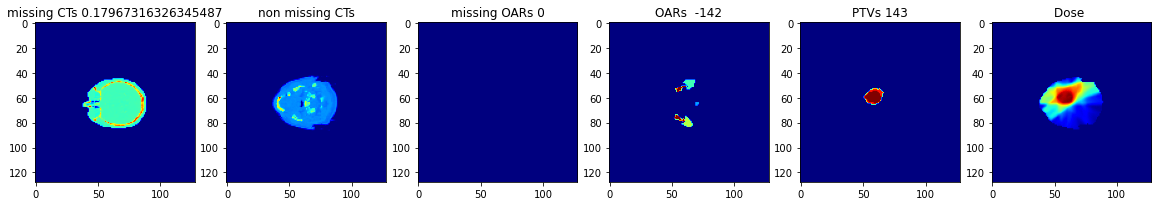

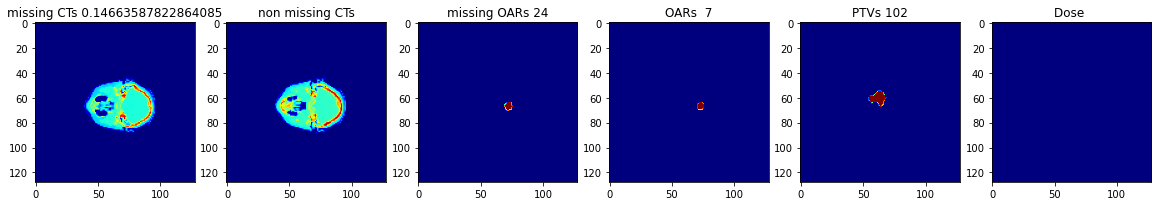

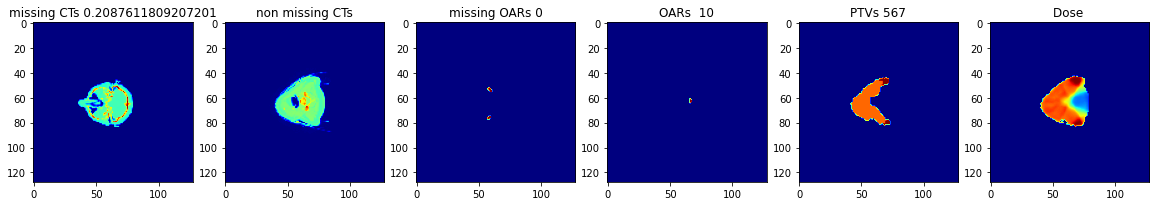

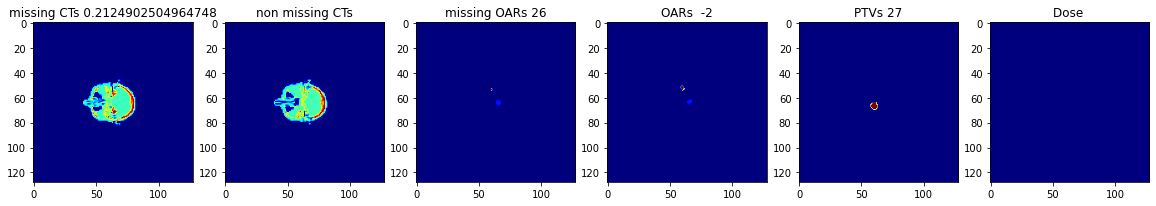

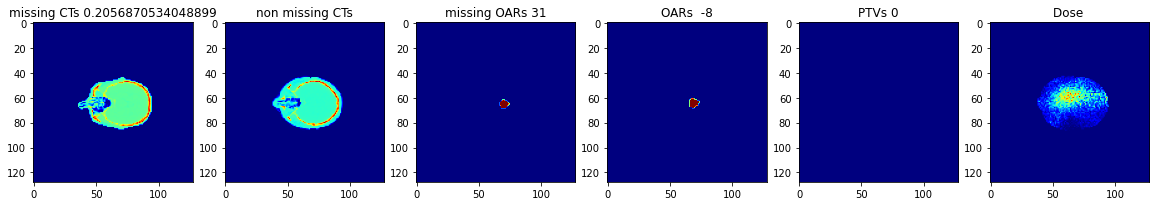

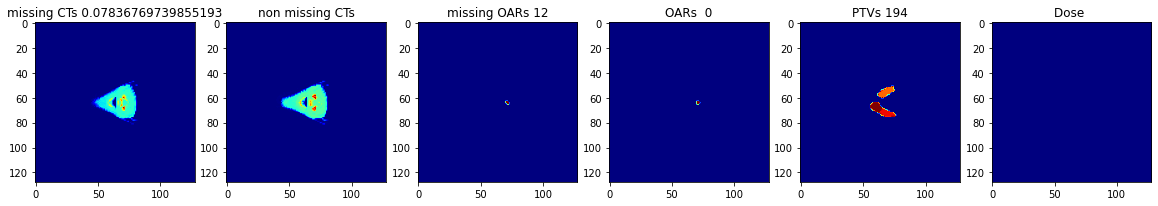

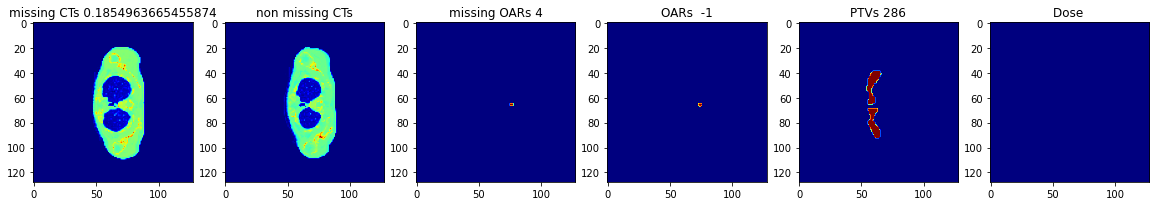

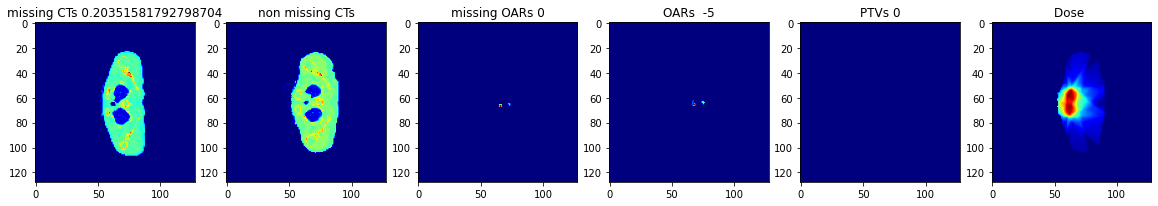

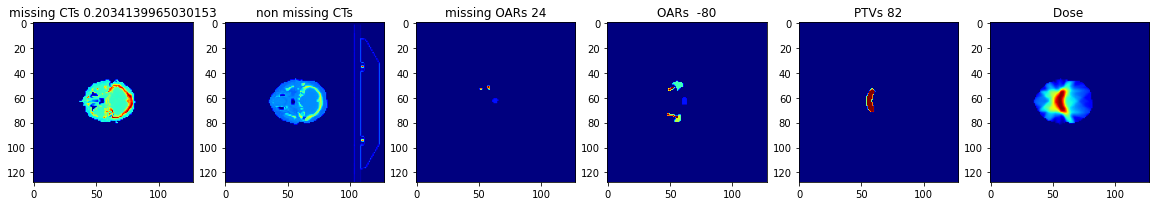

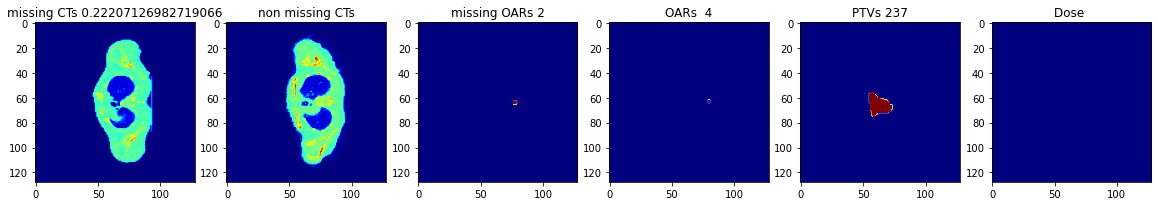

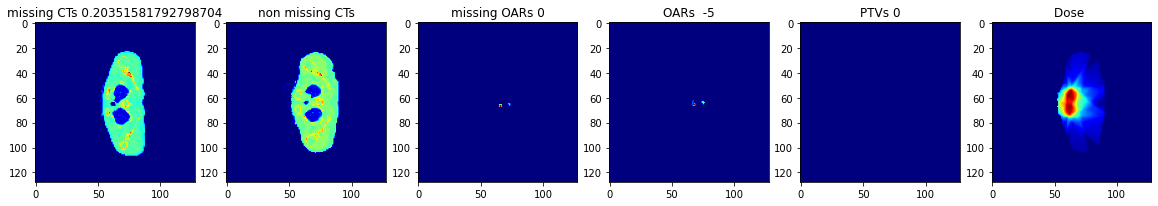

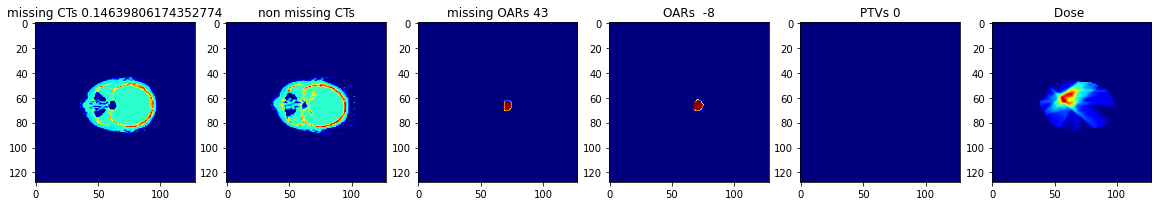

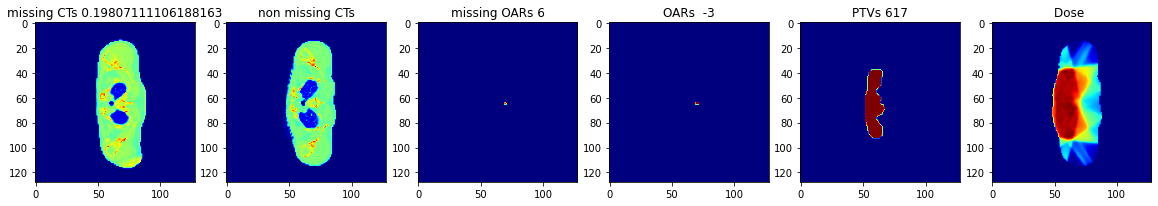

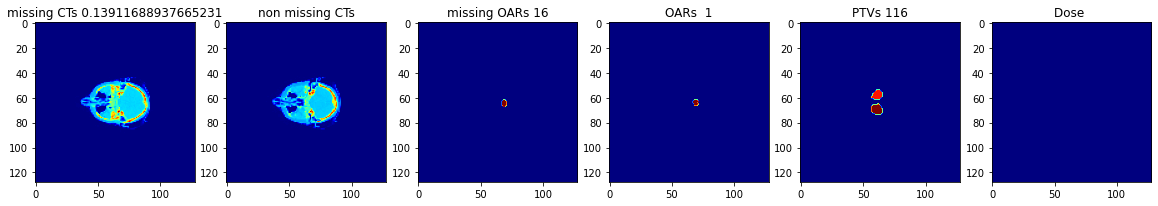

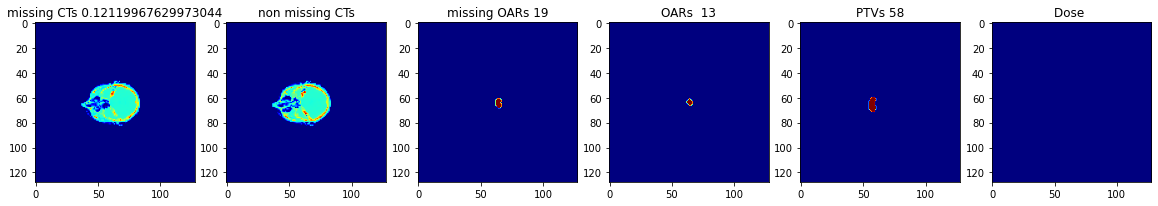

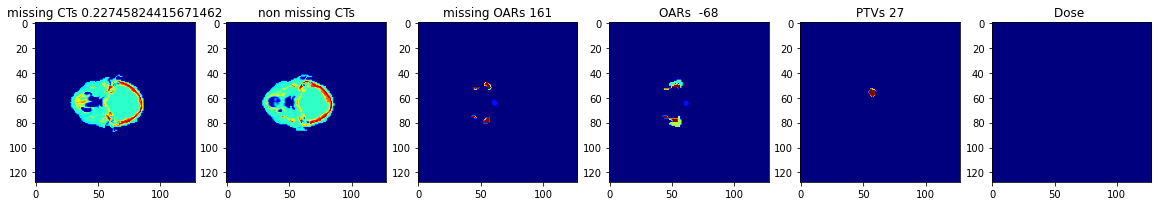

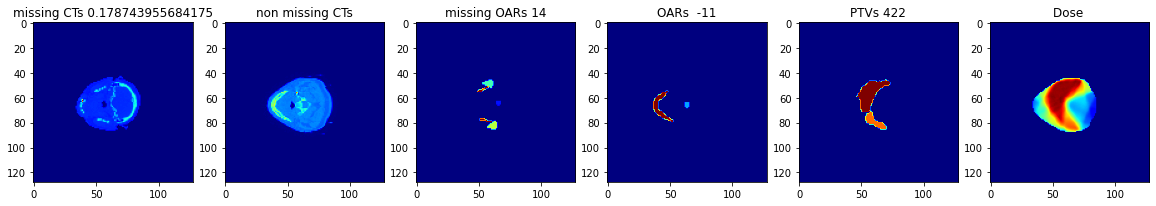

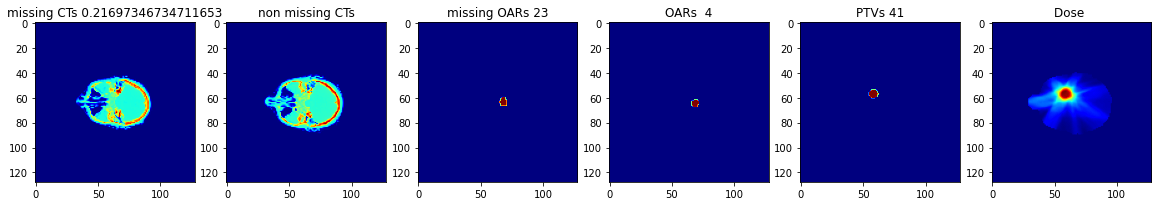

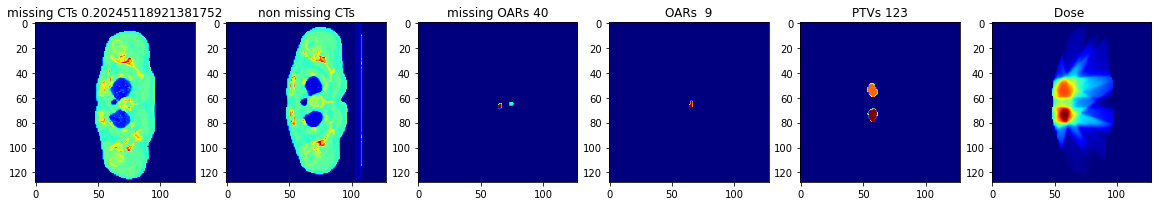

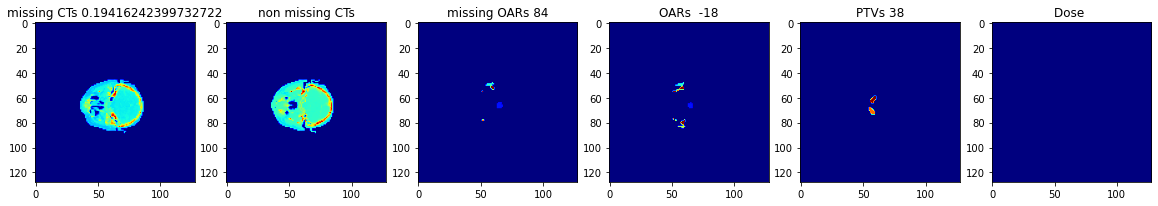

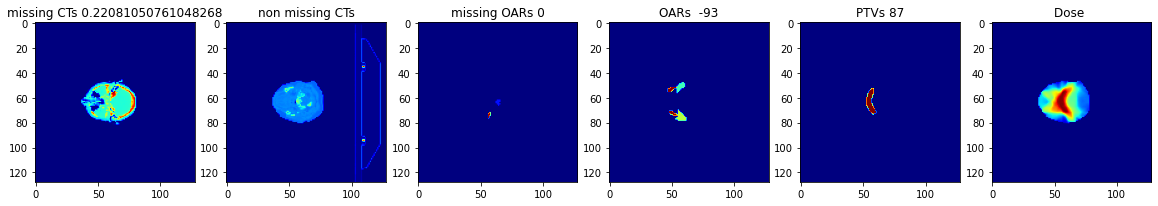

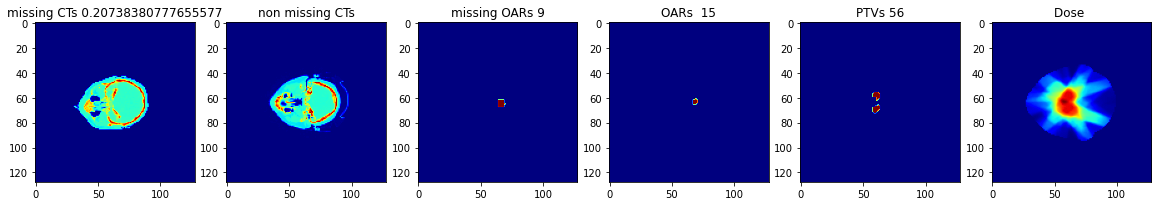

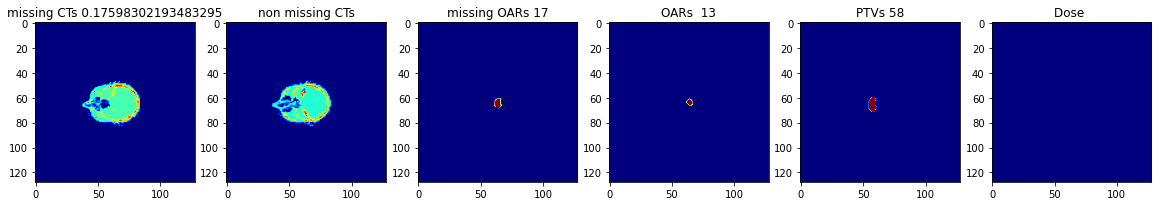

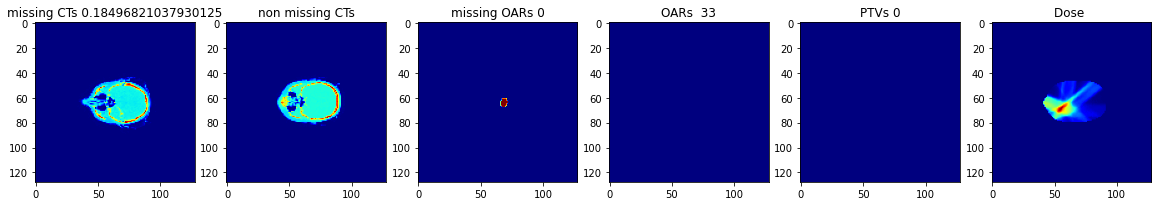

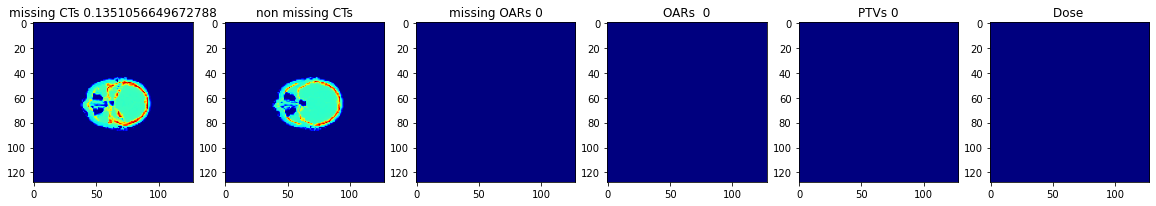

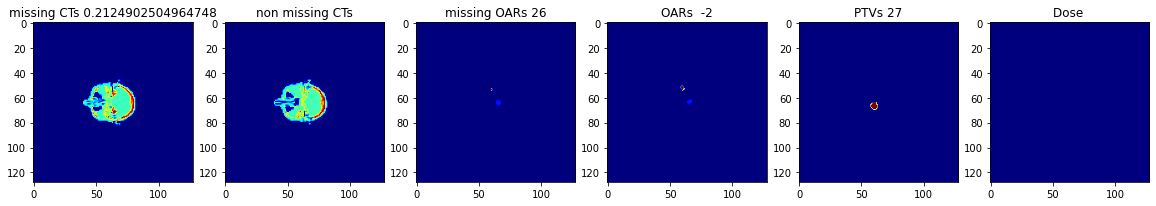

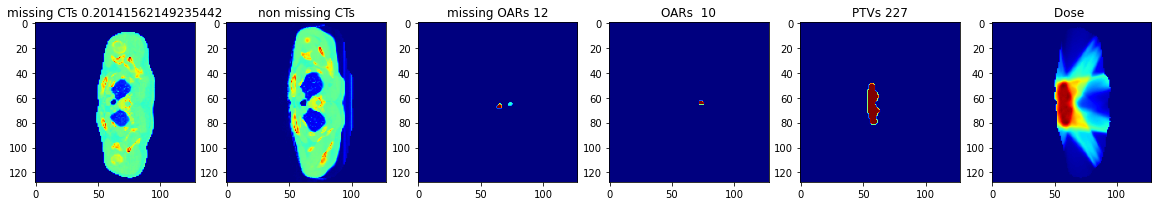

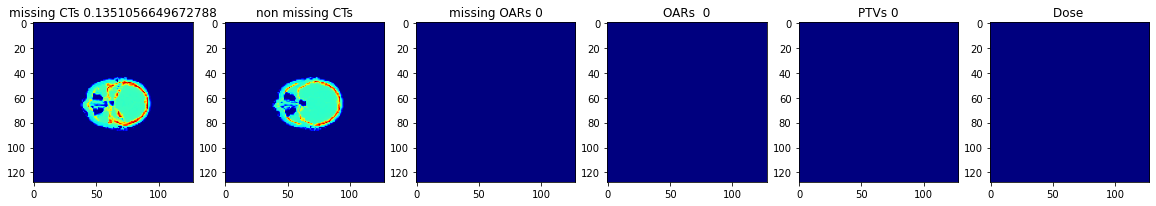

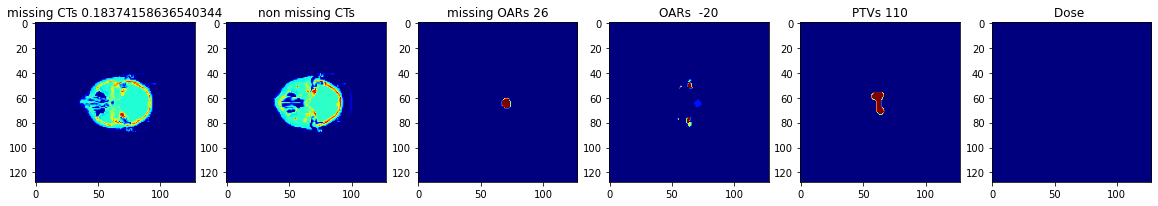

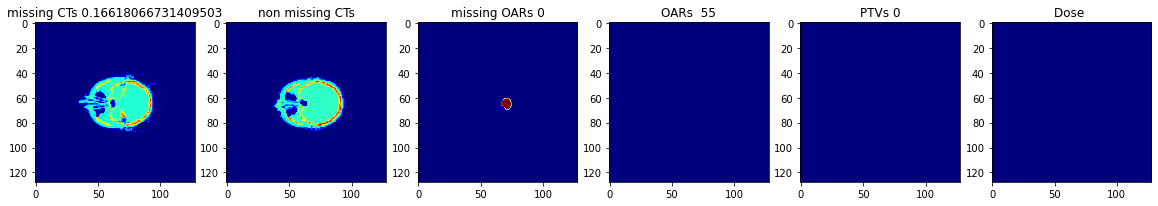

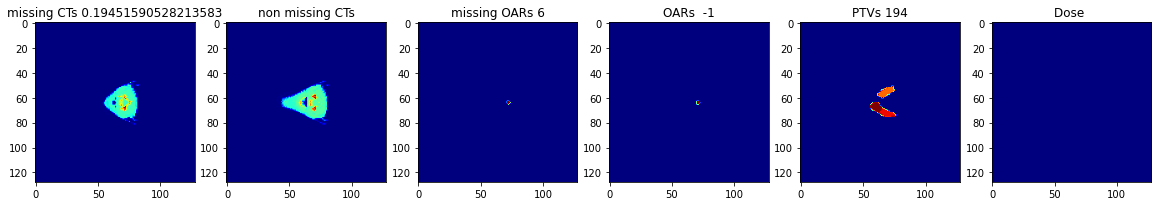

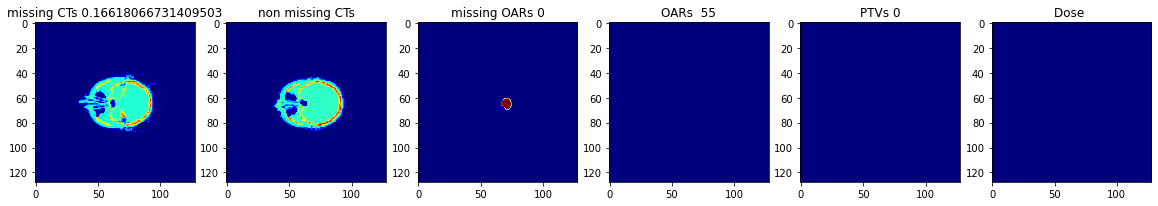

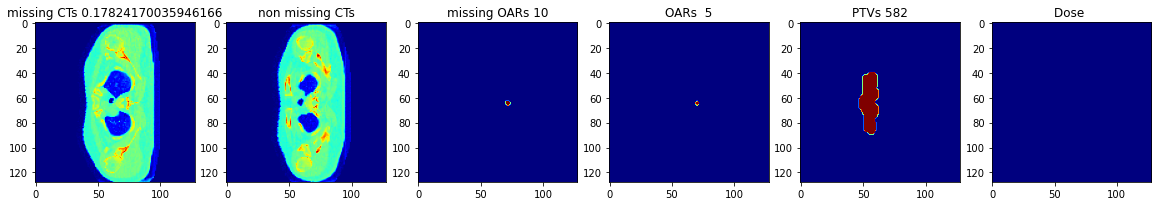

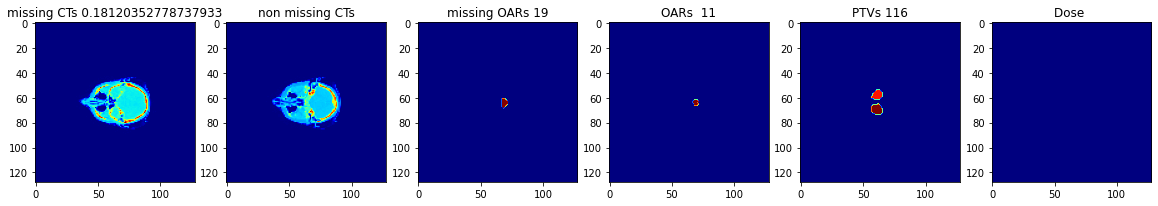

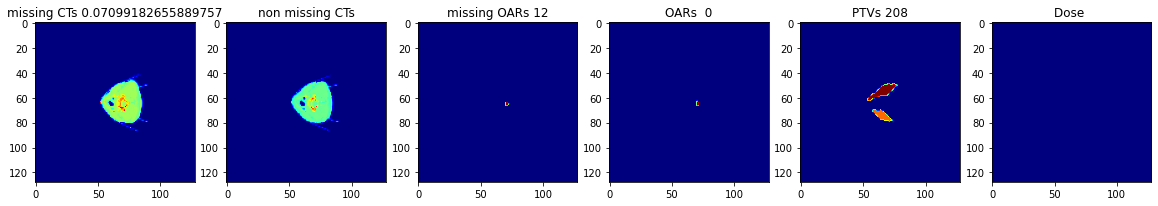

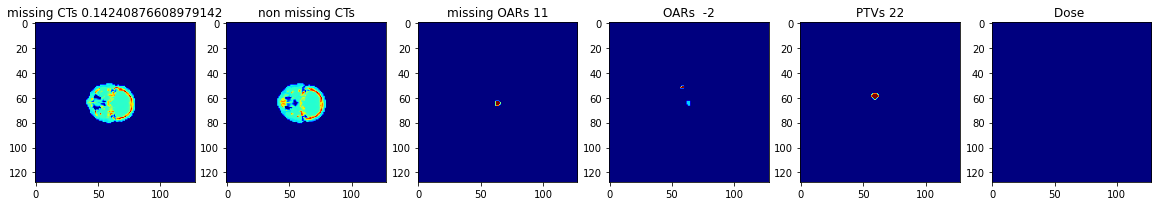

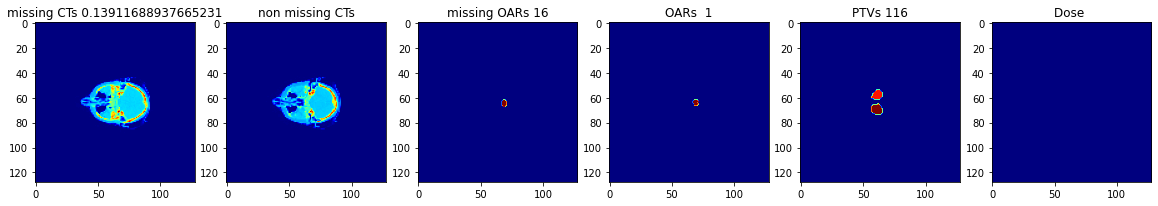

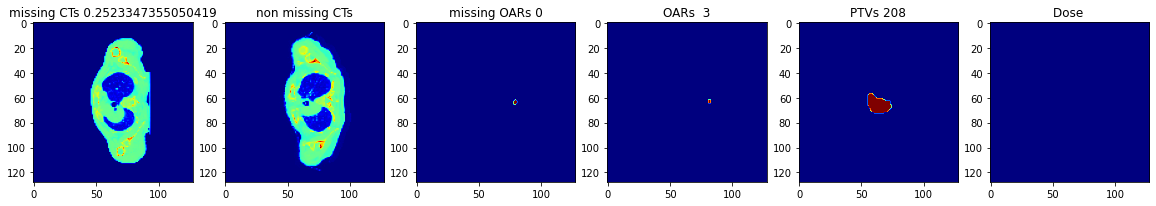

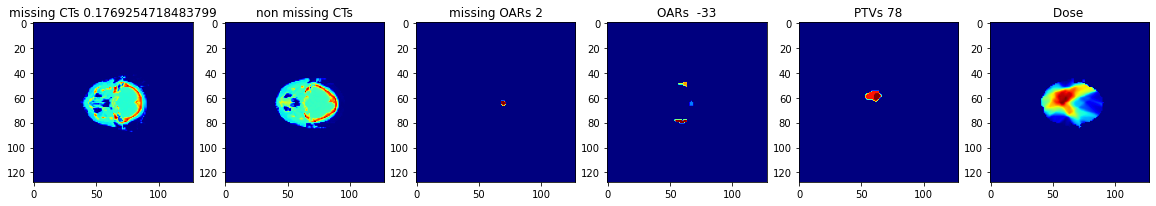

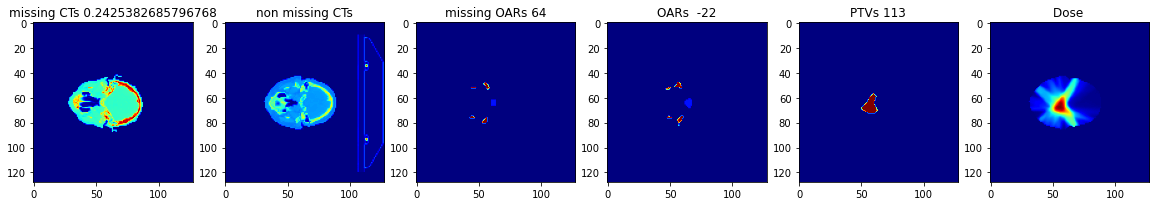

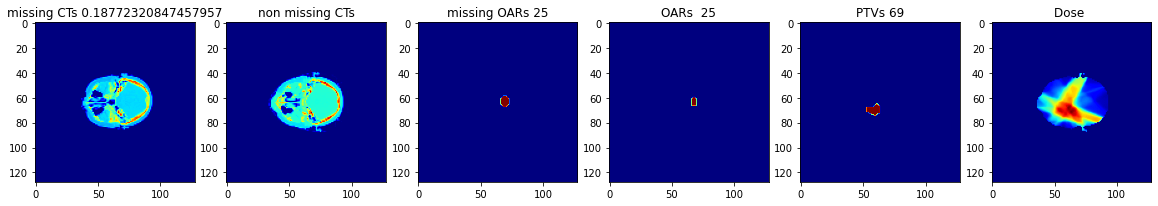

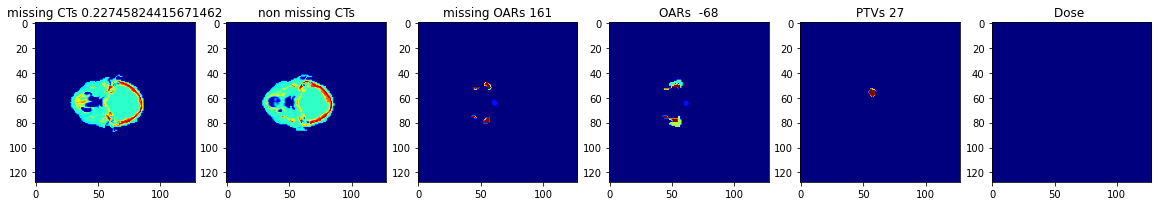

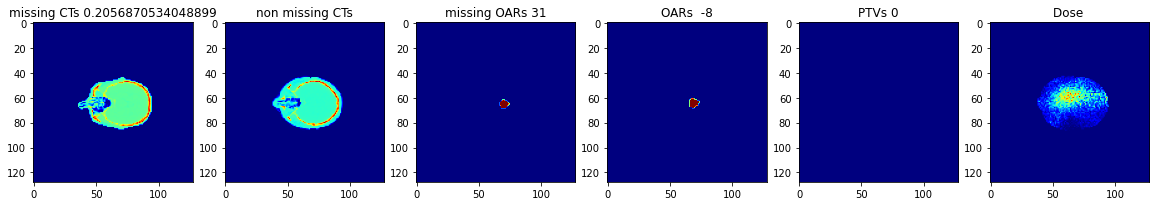

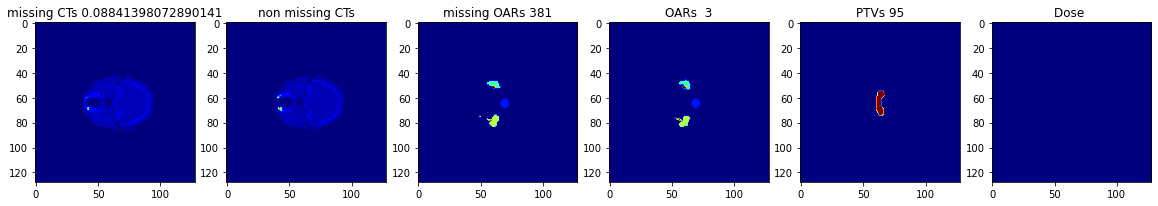

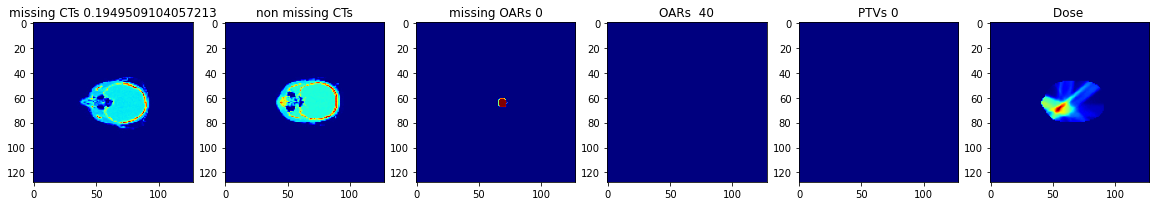

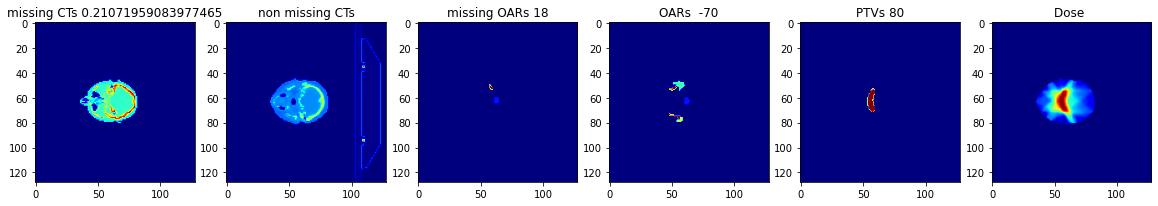

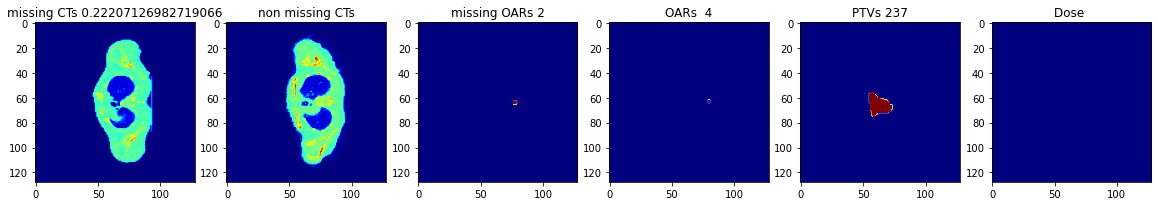

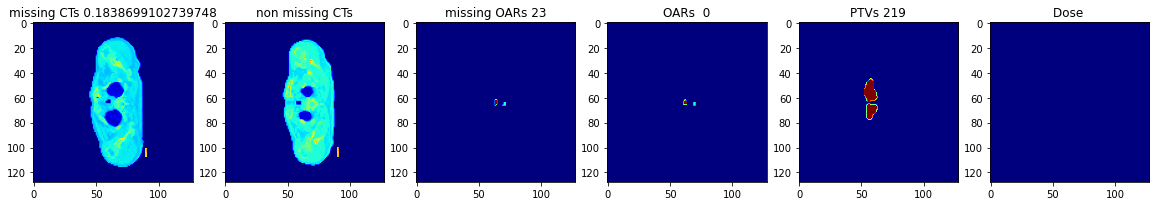

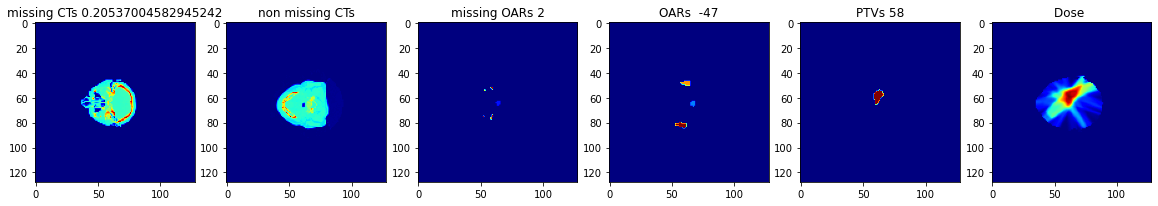

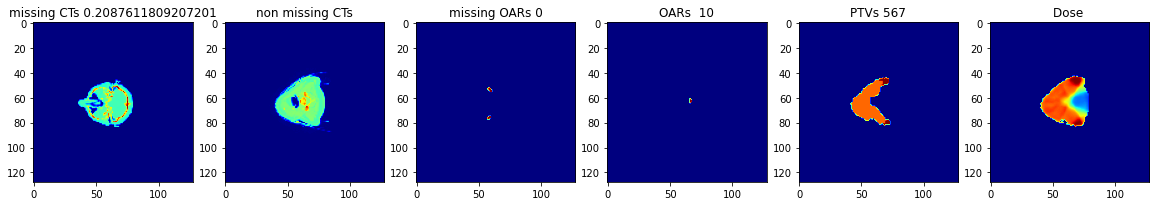

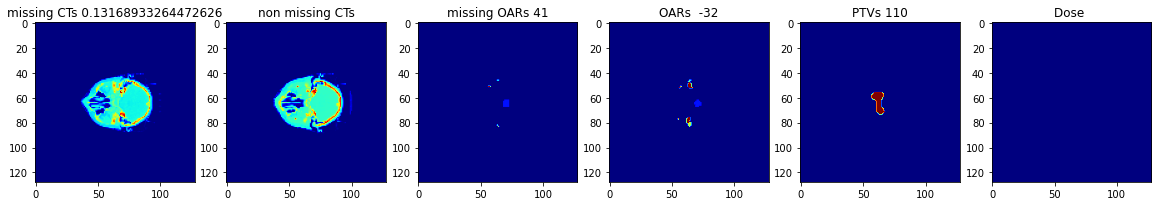

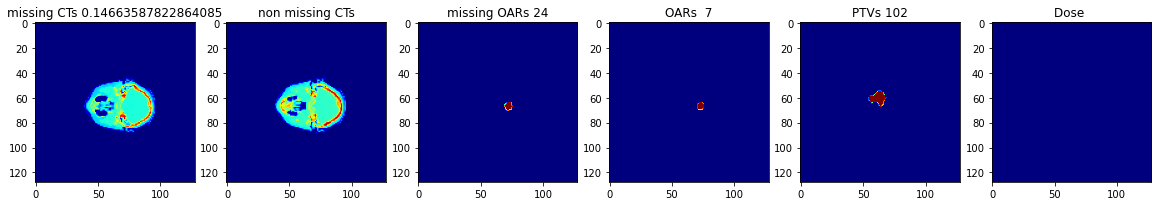

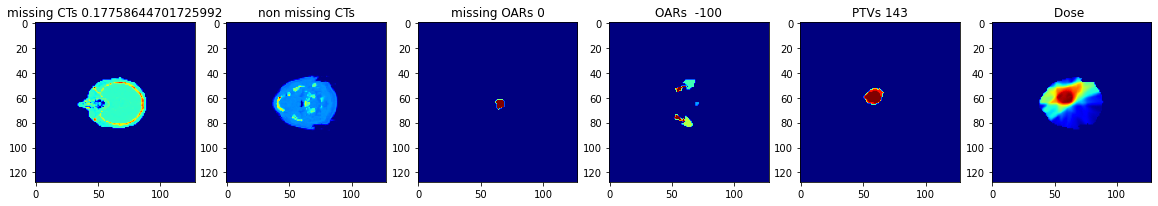

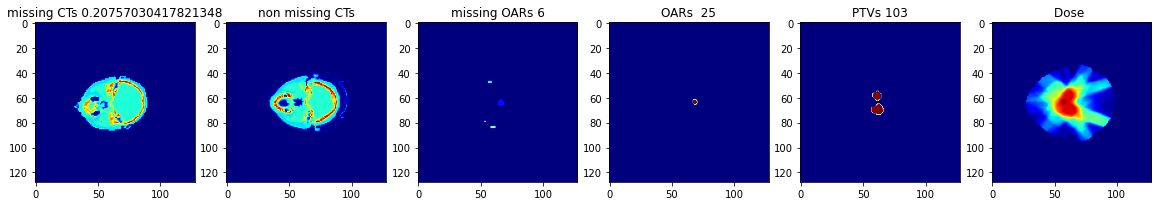

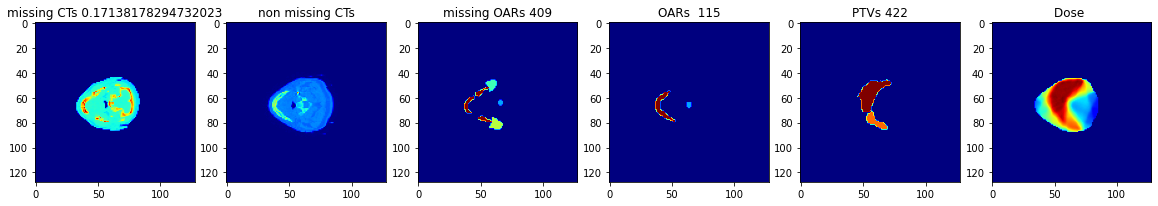

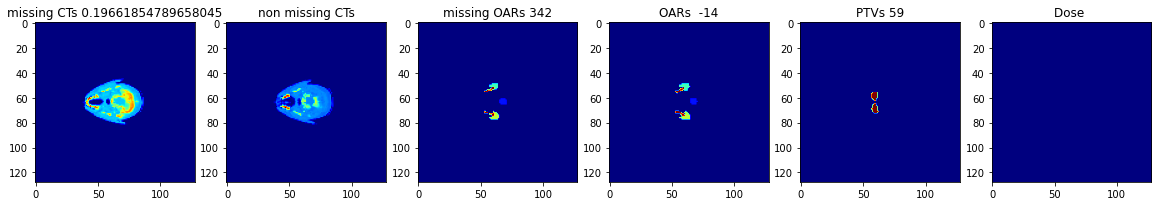

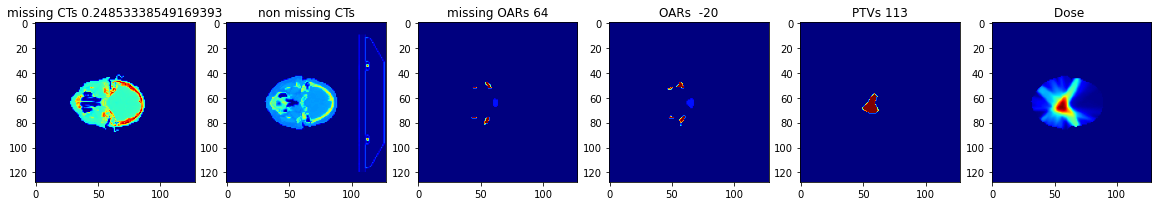

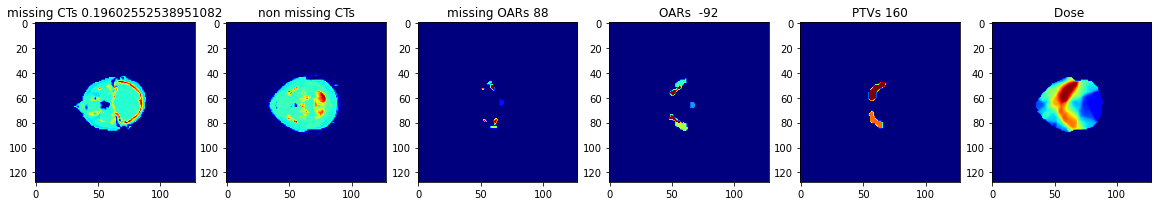

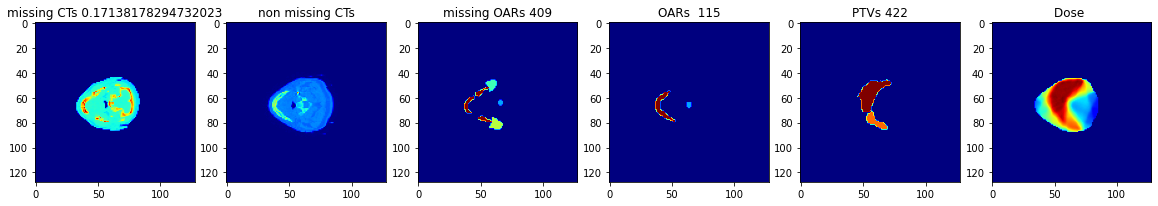

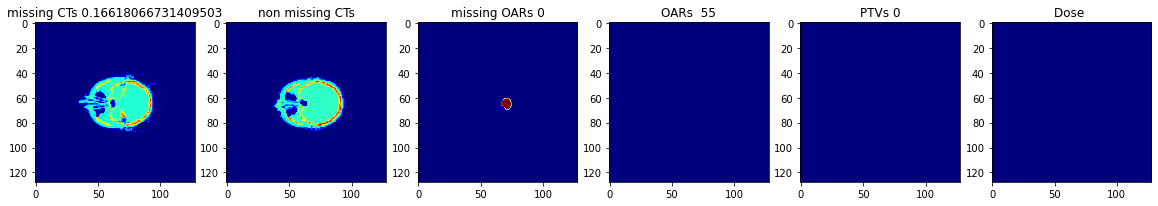

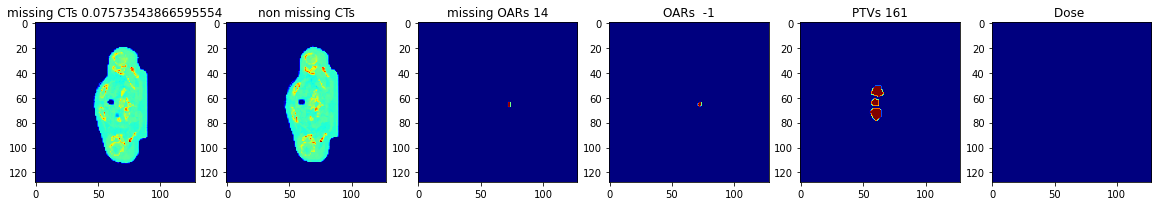

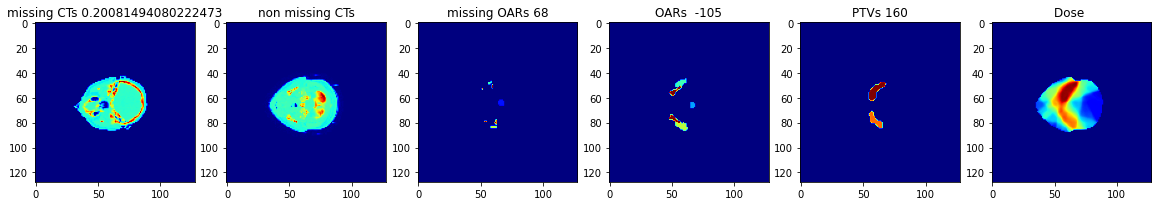

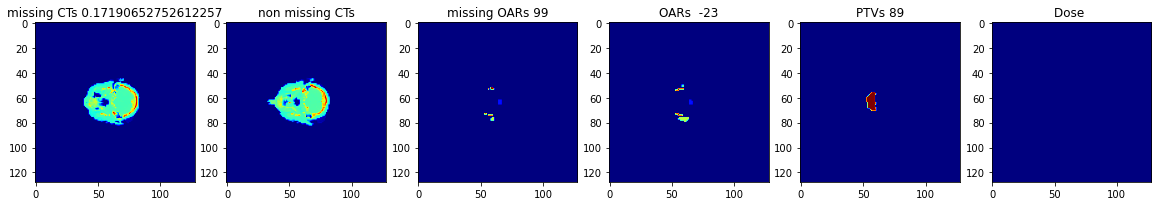

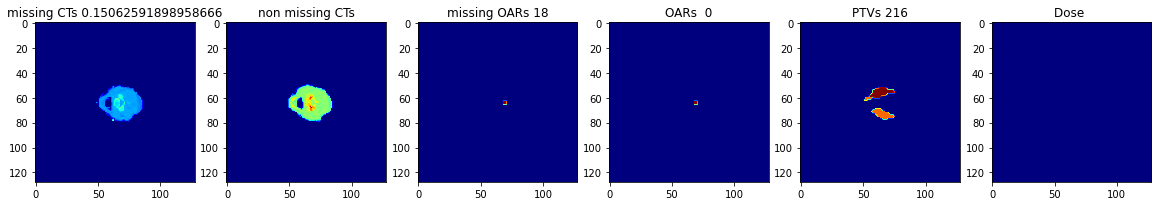

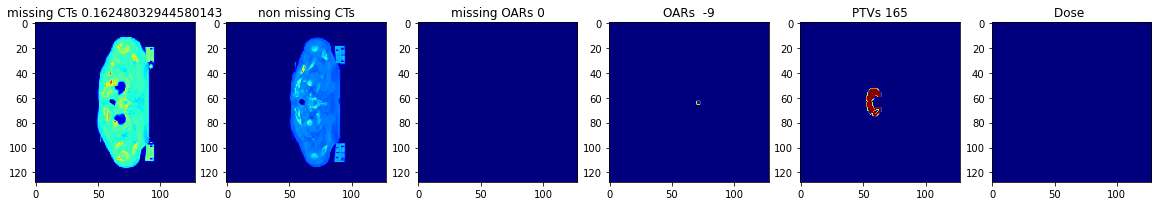

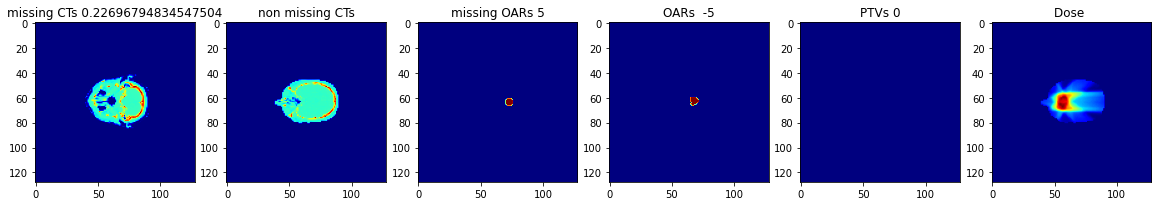

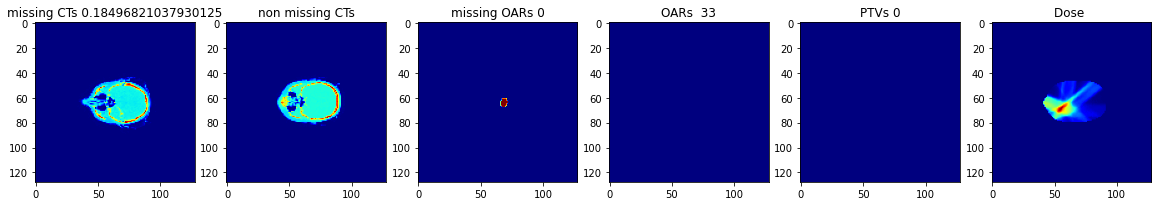

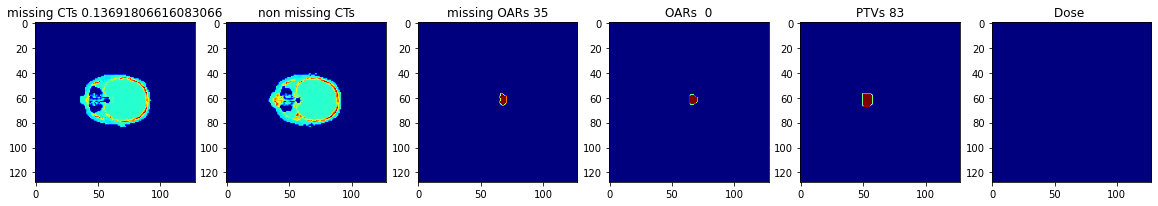

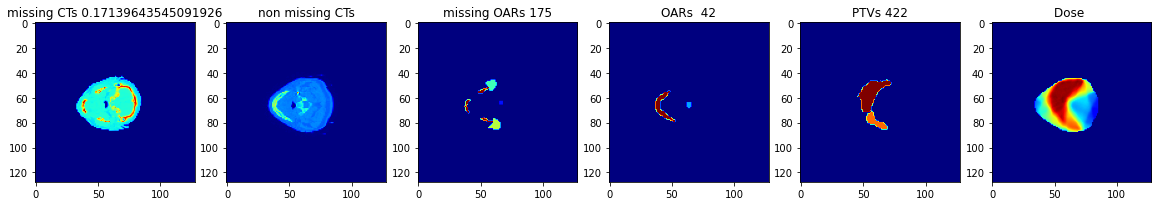

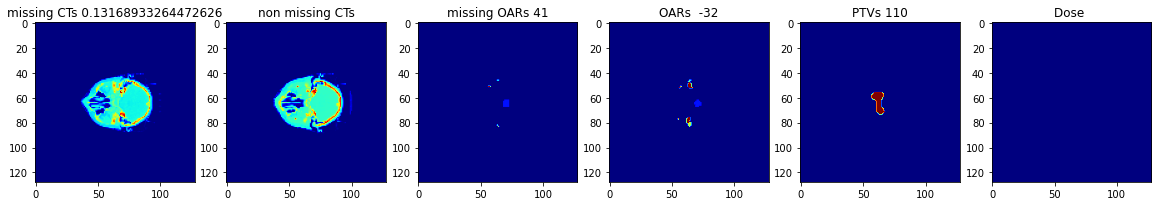

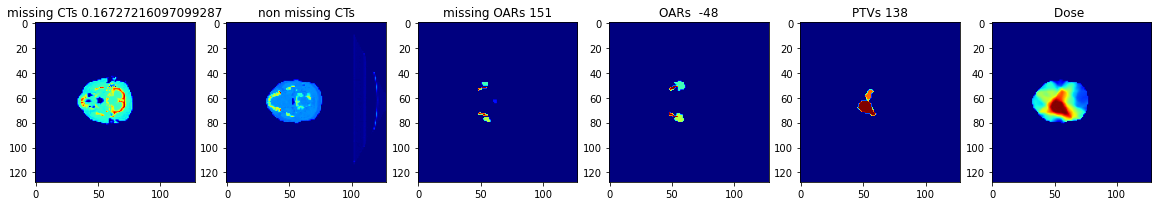

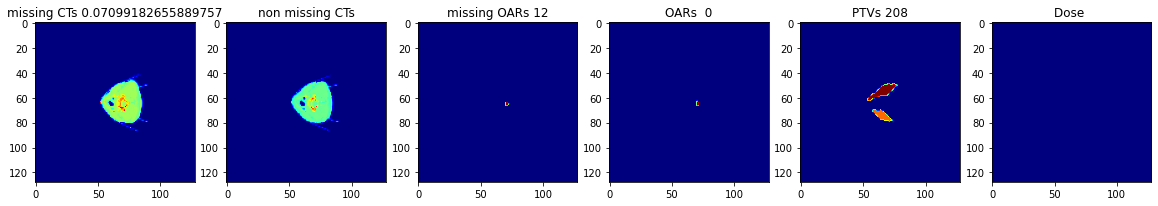

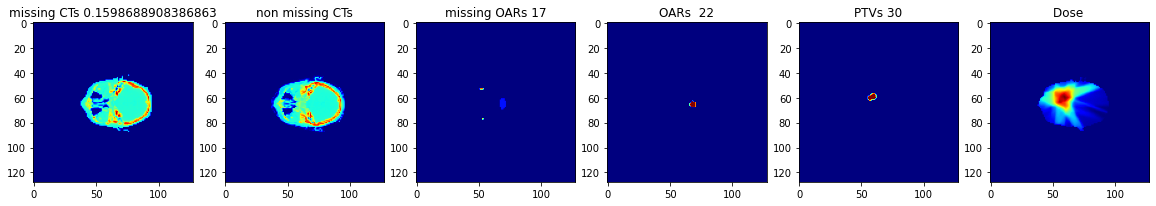

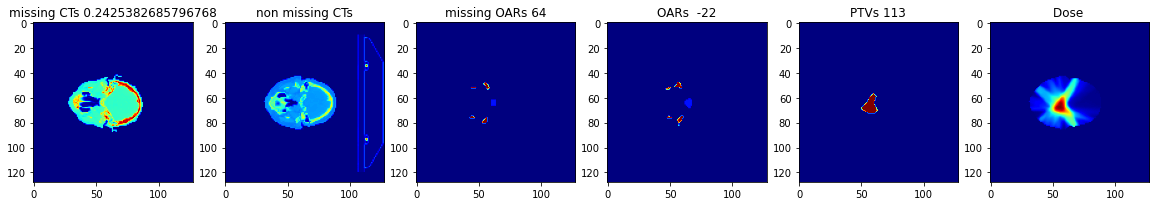

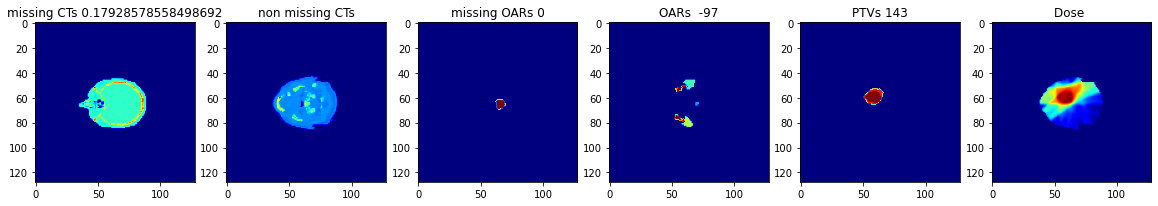

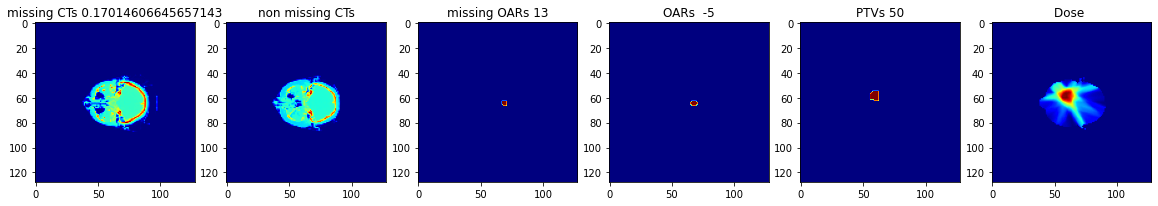

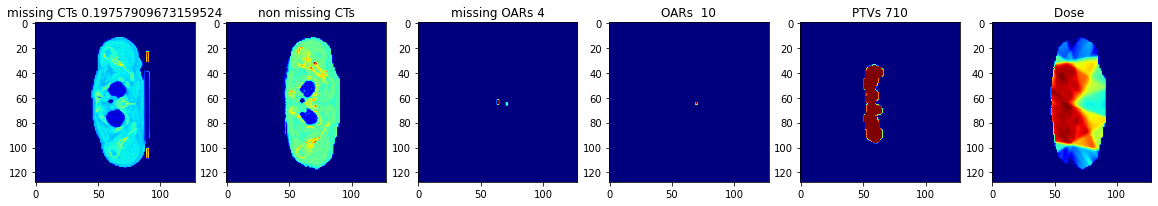

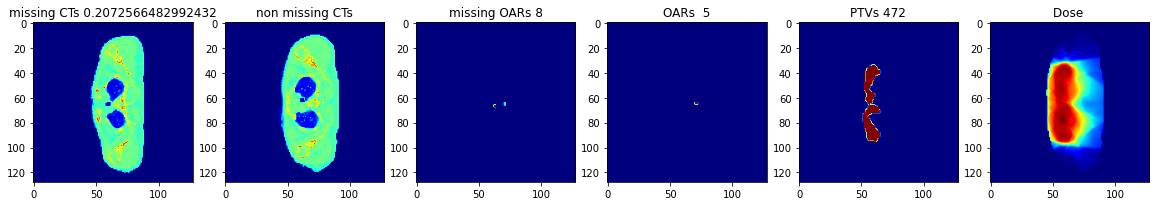

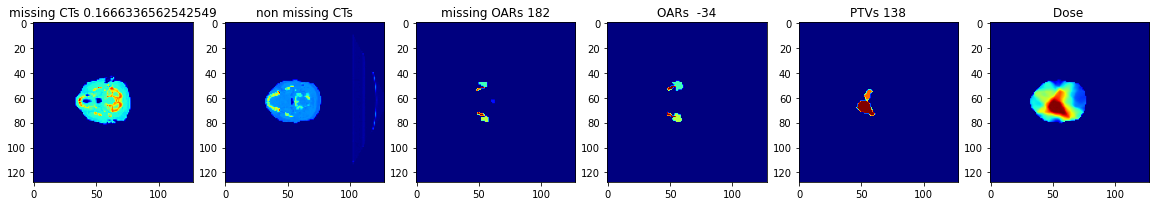

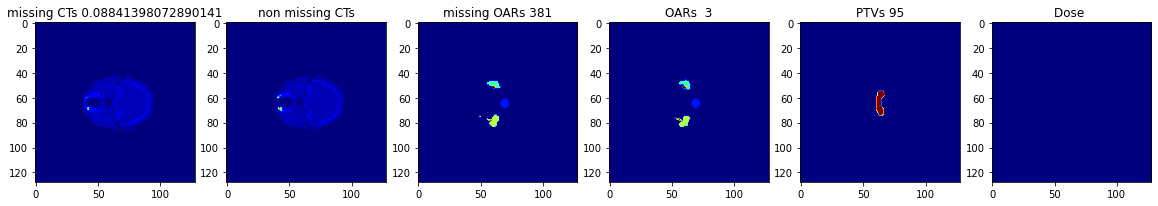

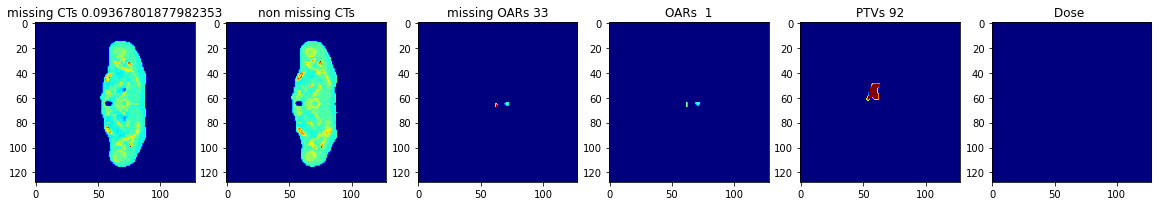

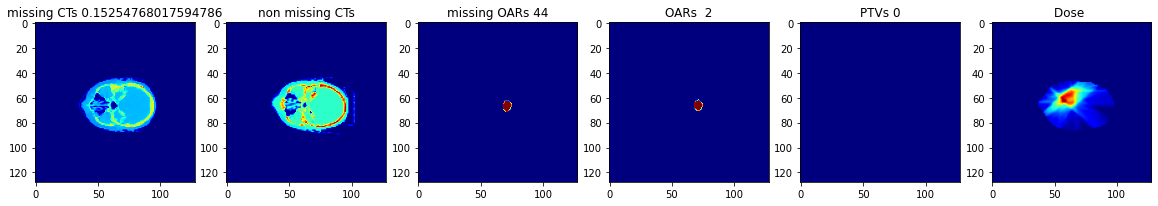

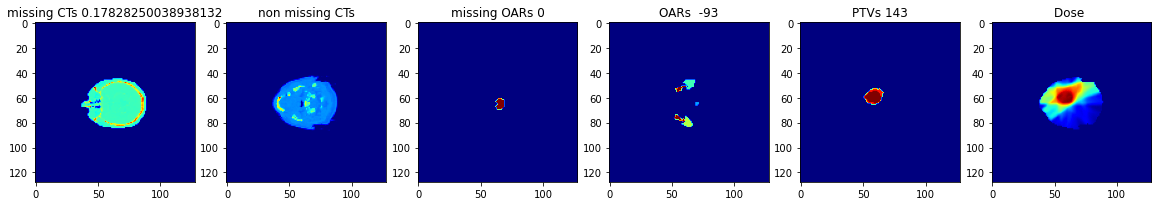

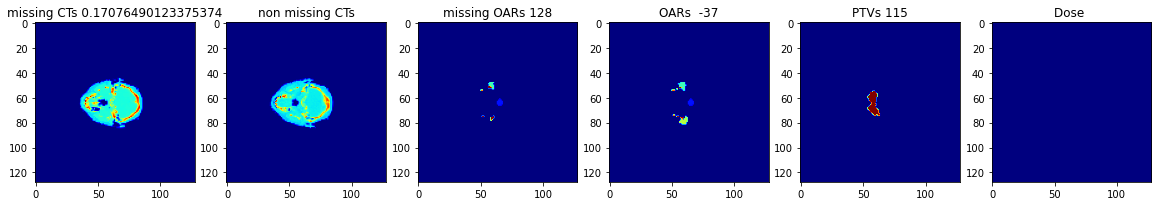

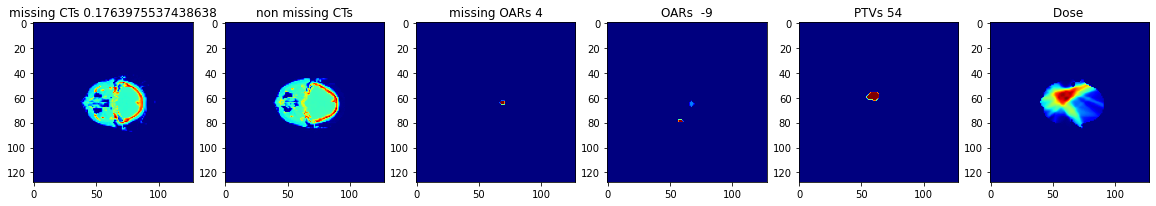

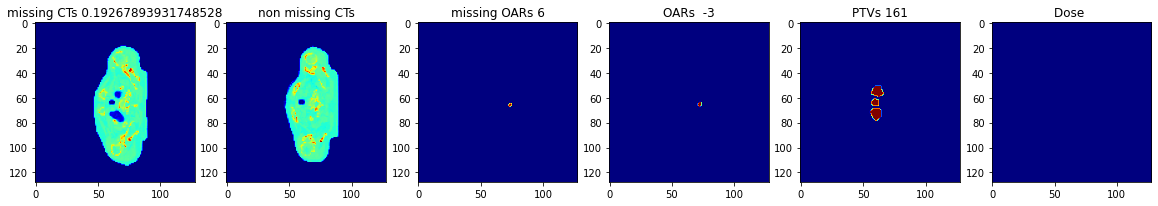

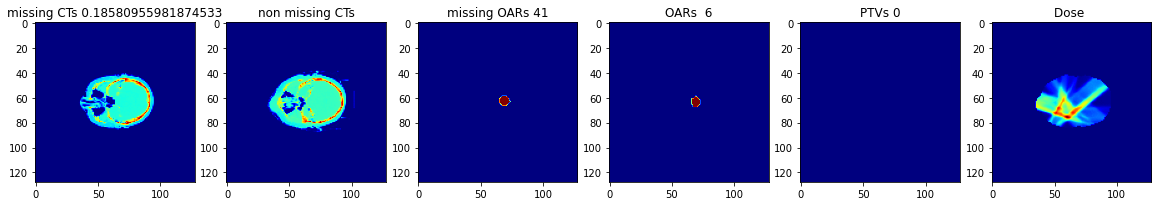

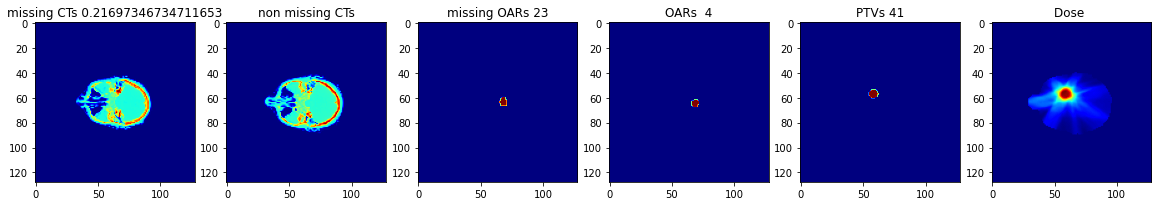

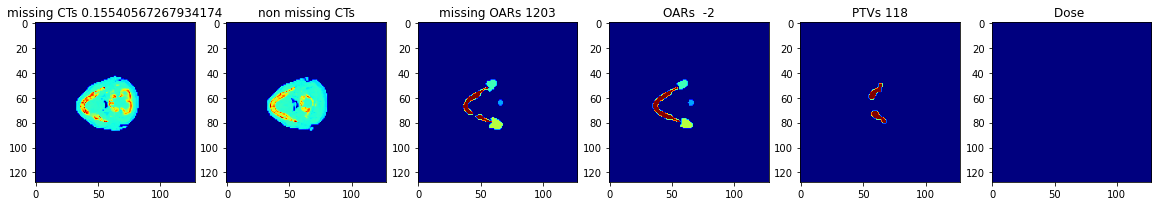

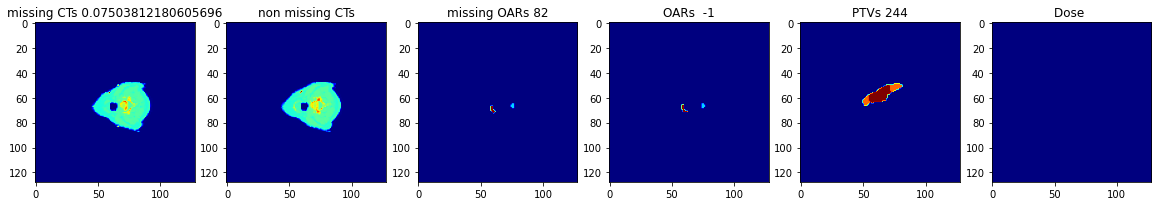

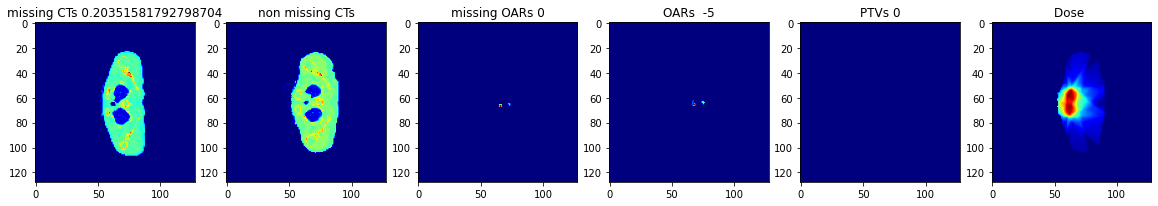

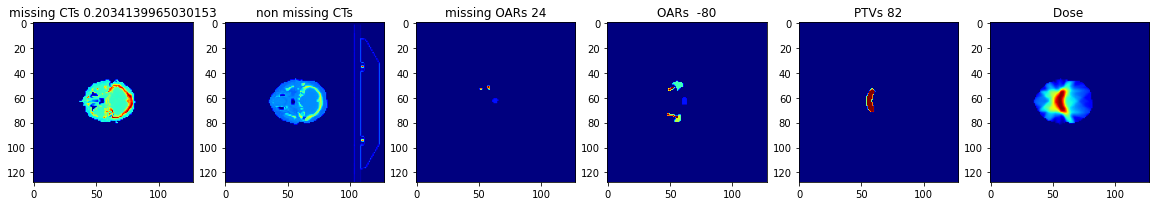

In [ ]:
missing_paths = np.array(data_paths)[missing_indices]
non_missing_paths = np.array(data_paths)[mask]
for i,ind in enumerate(pairwise_distance.argmin(axis=1)):
    nmiss_imgs = read_data(non_missing_paths[ind])
    miss_imgs = read_data(missing_paths[i])

    fig, axs = plt.subplots(ncols=6, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    axs[0, 0].set_title(f"missing CTs {pairwise_distance[i, ind]}")
    axs[0, 0].imshow(miss_imgs[2], cmap='jet')
    #axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("non missing CTs")
    axs[0, 1].imshow(nmiss_imgs[2], cmap='jet')

    axs[0, 2].set_title(f"missing OARs {(miss_imgs[1][0]*(miss_imgs[1][0]==nmiss_imgs[1][0])).sum() }")
    axs[0, 2].imshow(miss_imgs[1][0], cmap='jet')

    axs[0, 3].set_title(f"OARs  {(miss_imgs[1][0]>0).sum()-(nmiss_imgs[1][0]>0).sum() }")
    axs[0, 3].imshow(nmiss_imgs[1][0], cmap='jet')

    axs[0, 4].set_title(f"PTVs {(nmiss_imgs[0]>0).sum()}")
    axs[0, 4].imshow(nmiss_imgs[0], cmap='jet')

    axs[0, 5].set_title(f"Dose ")
    axs[0, 5].imshow(nmiss_imgs[-1], cmap='jet')
    plt.show()

    

#### Predict missing PTVs using CT scan and OARs

In [2]:
model_name = '' #AUTO, DCNN, DCNN_2ENC
bottleneck = '' #None, Vit, DFA


PATH = 'Output/DCNN_None_ROI_LOSS_ptv/best_val_evaluation_uloss.pkl'


train, val, test = get_loader('data', train_bs=32,
        val_bs=1,
        test_bs=1,
        train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
        val_num_samples_per_epoch=1200,
        test_num_samples_per_epoch=1200,
        num_works=1,
        resplit=False,
        seed=199,#199
        with_miss_PTVs=True,
        with_distance=True,
        PTV_estimate=True
    )



In [37]:
path='Output/DCNN_None_ROI_LOSS_ptv1/best_val_evaluation_uloss.pkl'

model1 = Model(in_ch=2, out_ch=5,list_ch=[-1, 32, 64, 128, 256], PTV_estimator=True)
model1.load_state_dict(torch.load(path)['network_state_dict'])
model1 = model1.eval()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


0it [00:00, ?it/s]

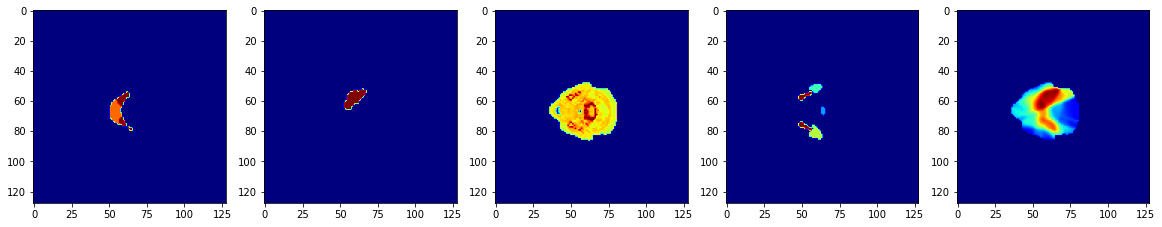

1it [00:00,  1.54it/s]

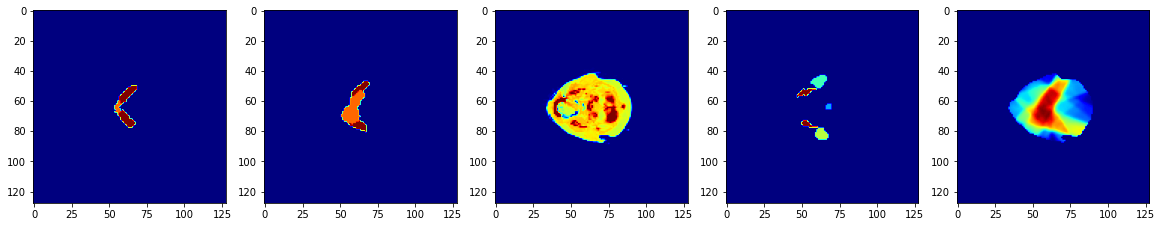

2it [00:01,  1.58it/s]

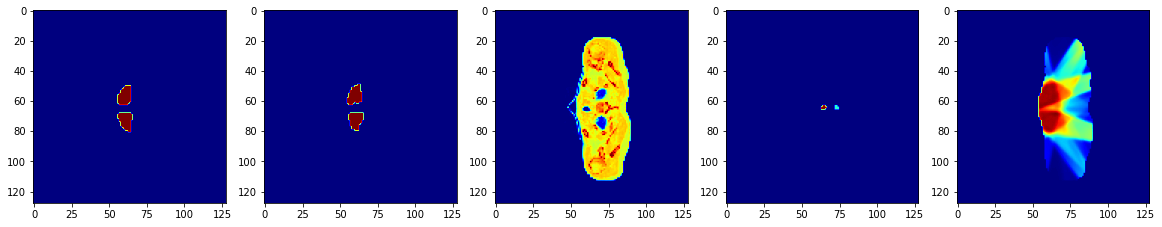

3it [00:01,  1.90it/s]

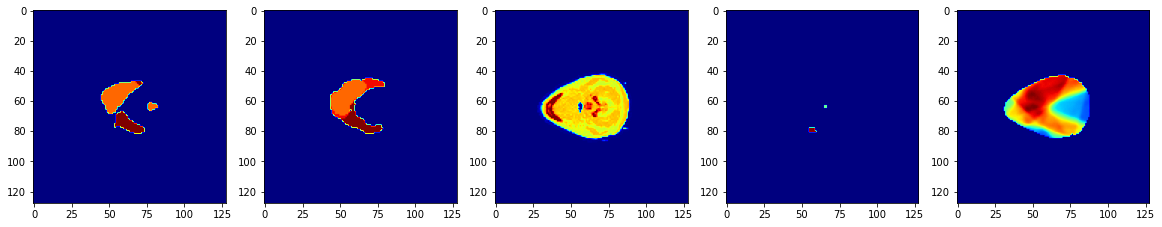

4it [00:02,  2.09it/s]

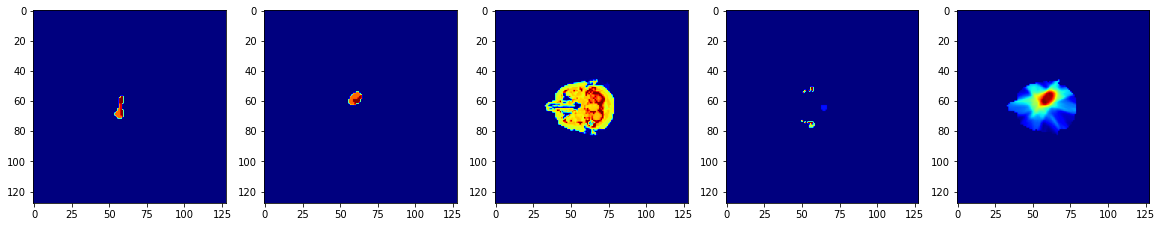

5it [00:02,  2.27it/s]

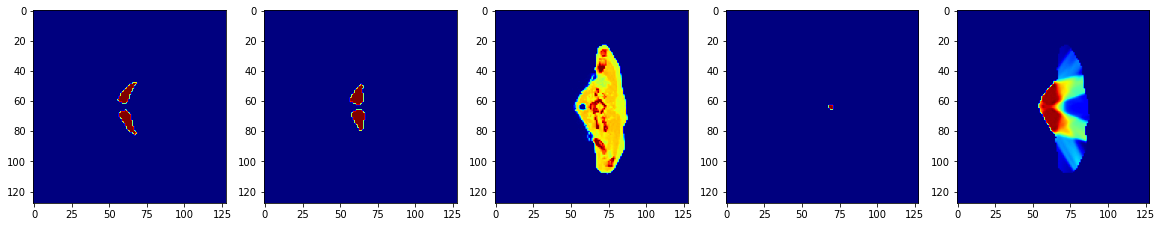

6it [00:02,  2.39it/s]

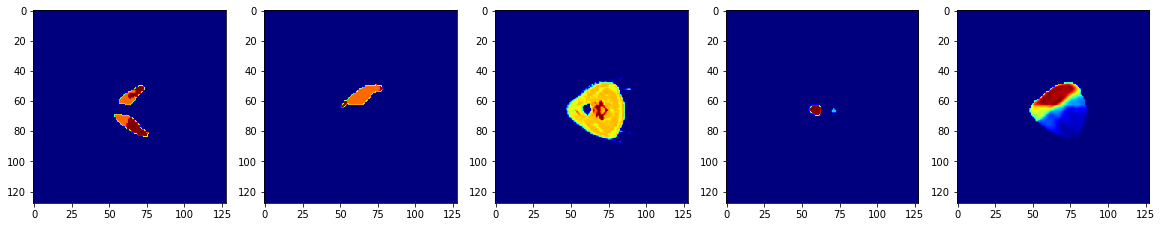

7it [00:03,  2.47it/s]

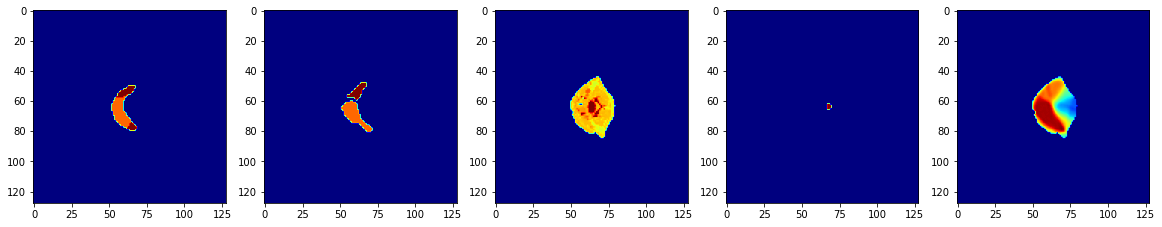

8it [00:03,  2.18it/s]

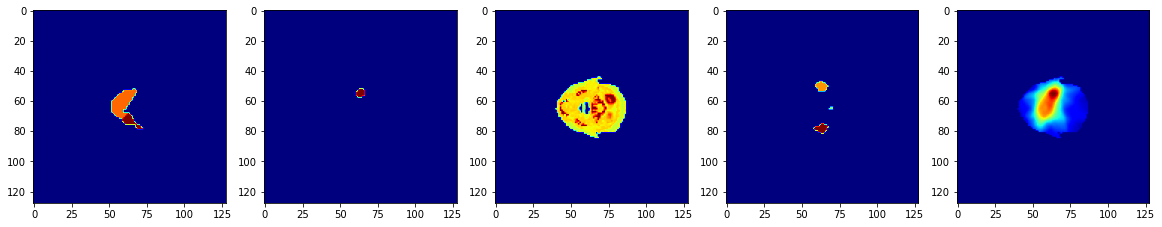

9it [00:04,  2.31it/s]

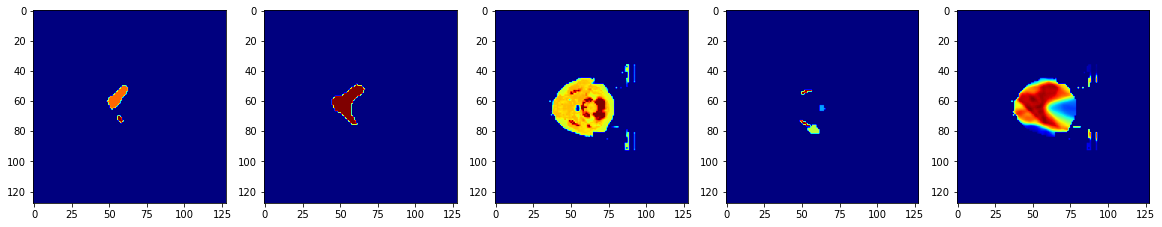

10it [00:04,  2.42it/s]

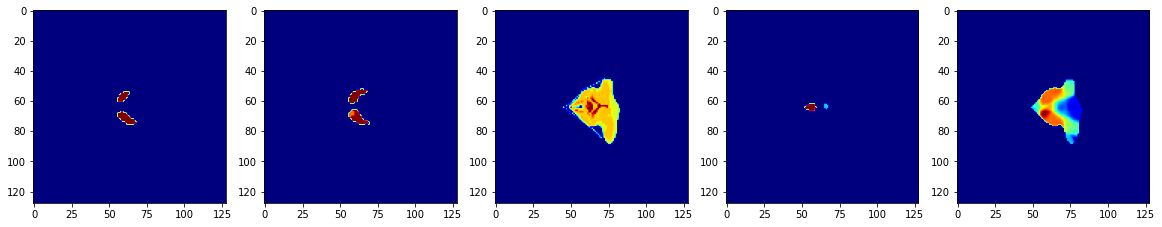

10it [00:04,  2.05it/s]


In [38]:
from DCNN.loss import L1Loss

loss_artif = []
loss = []
Visualize = True

loss_fn= L1Loss()

for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]['data'][0]
    target = list_loader_output[0]['data'][1][0]
    dose = list_loader_output[0]['data'][3][0]
    mask = list_loader_output[0]['data'][2][0][0]
    #if target[:3].sum()!=0 or mask.sum()==0:
    #    continue
    
    output = model1(input_)
    fig, axs = plt.subplots(ncols=5, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    output = (4-output[0].detach()[0].numpy().argmax(axis=0))
    output[output<=1] = 0
    ptv_pred = 1.*(output==4) + 63/70*(output==3) + 56/70*(output==2)
    ptv_gt = 1.*target[0] + 63/70*target[1] + 56/70*target[2]
    axs[0,0].imshow(ptv_pred*mask.detach().numpy(), cmap='jet')
    
    axs[0,1].imshow(ptv_gt, cmap='jet')
    
    axs[0,2].imshow(input_[0,0], cmap='jet')
    
    axs[0,3].imshow(input_[0,1], cmap='jet')

    axs[0,4].imshow(dose[0], cmap='jet')
    plt.show()
    if batch_idx>=10:
        break
    
    
    

### Test the trained models

In [4]:
paths=['Output/DCNN_Vit_None_L1LOSS/best_val_evaluation_uloss.pkl',
        'Output/DCNN_Vit_None_ROI_SM_LOSS/best_val_evaluation_uloss.pkl',
        'Output/DCNN_Vit_None_ROI_LOSS/best_val_evaluation_uloss.pkl',
        'Output/DCNN_2ENC_None_ROI_LOSS/best_val_evaluation_uloss.pkl',
        'Output/DCNN_2ENC_None_ROI_SM_LOSS/best_val_evaluation_uloss.pkl',
        'Output/DCNN_2ENC_None_L1LOSS/best_val_evaluation_uloss.pkl'
        ]
models=[]
model1 = Model(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256], bottleneck='Vit')
model2 = Model(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256], bottleneck='Vit')
model3 = Model(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256], bottleneck='Vit')
        
model4 = Model_sep(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256])
model5 = Model_sep(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256])
model6 = Model_sep(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256])

model1.load_state_dict(torch.load(paths[0])['network_state_dict'])
models.append(model1)
model2.load_state_dict(torch.load(paths[1])['network_state_dict'])
models.append(model2)
model3.load_state_dict(torch.load(paths[2])['network_state_dict'])
models.append(model3)
model4.load_state_dict(torch.load(paths[3])['network_state_dict'])
models.append(model4)
model5.load_state_dict(torch.load(paths[4])['network_state_dict'])
models.append(model5)
model6.load_state_dict(torch.load(paths[5])['network_state_dict'])
models.append(model6)

/home/infres/ahmad-21/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


In [5]:
model = Ensemble(models)
#model.load_state_dict(torch.load(PATH,  map_location='cuda:1')['network_state_dict'])
#model = model.eval()

#model1 = Model_sep(in_ch=4, out_ch=1,list_ch=[-1, 32, 64, 128, 256])
#model1.load_state_dict(torch.load(PATH1,  map_location='cuda:1')['network_state_dict'])
#model1 = model1.eval()
#
#model2 = Model_sep(in_ch=4, out_ch=1,list_ch=[-1, 32, 64, 128, 256])
#model2.load_state_dict(torch.load(PATH2,  map_location='cuda:1')['network_state_dict'])
#model2 = model2.eval()

In [8]:
output = model(input_)

### Validation

0it [00:00, ?it/s]

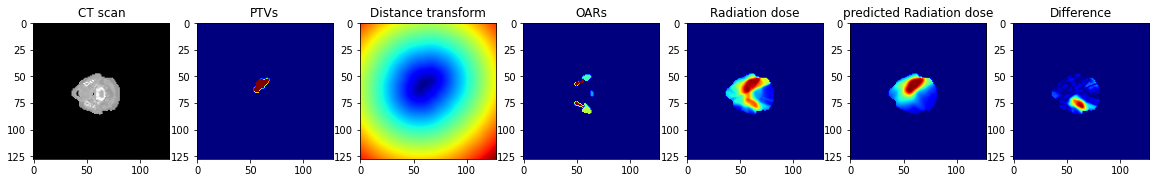

1it [00:01,  1.69s/it]

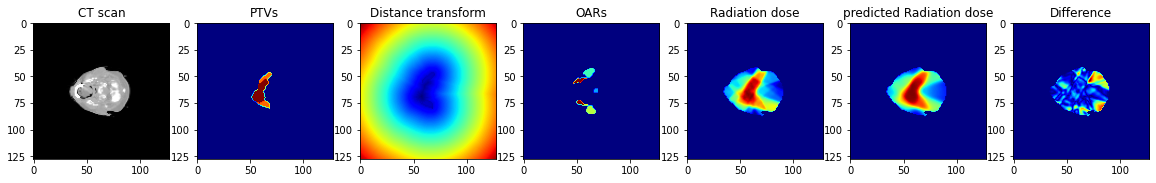

2it [00:03,  1.63s/it]

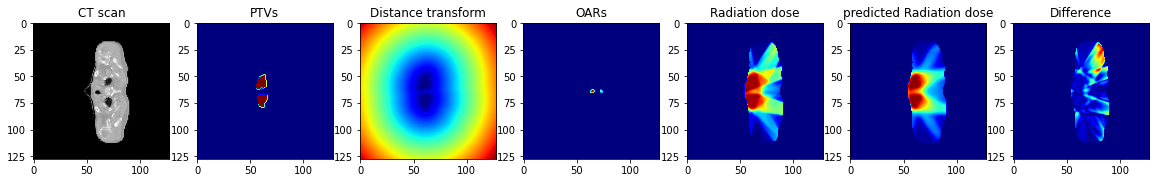

3it [00:04,  1.51s/it]

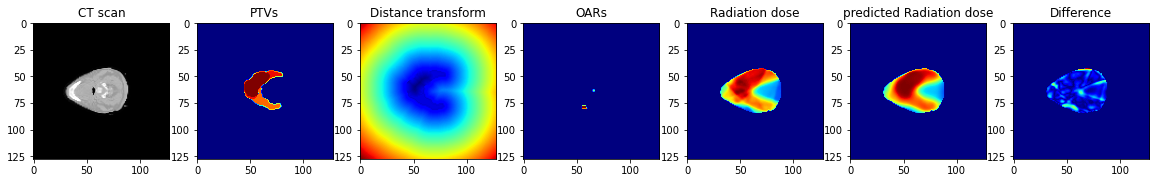

4it [00:05,  1.44s/it]

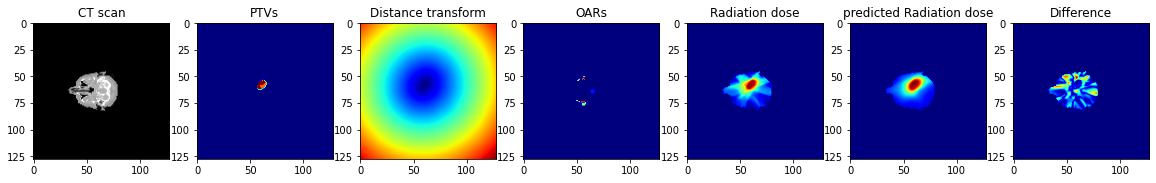

5it [00:07,  1.39s/it]

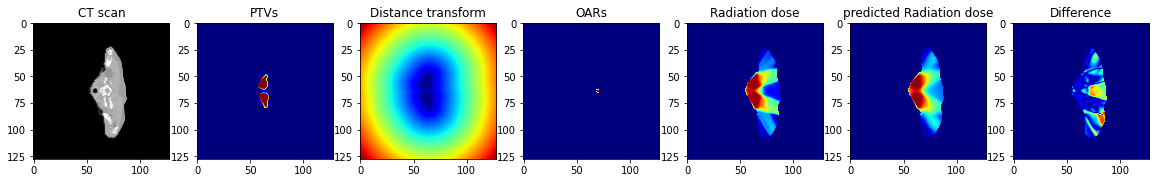

6it [00:08,  1.42s/it]

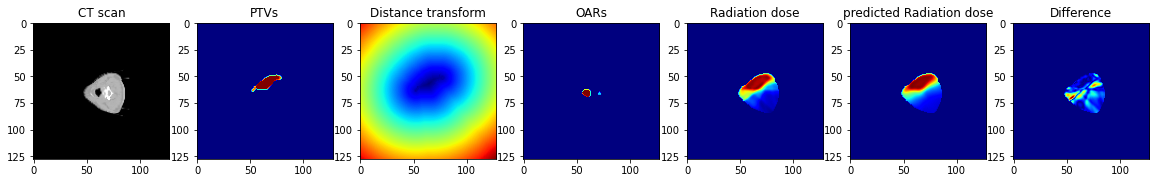

7it [00:10,  1.40s/it]

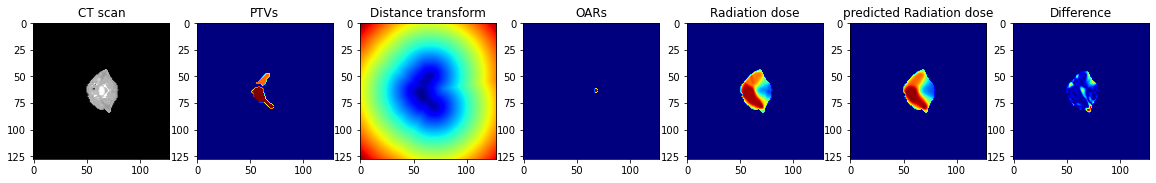

8it [00:11,  1.45s/it]

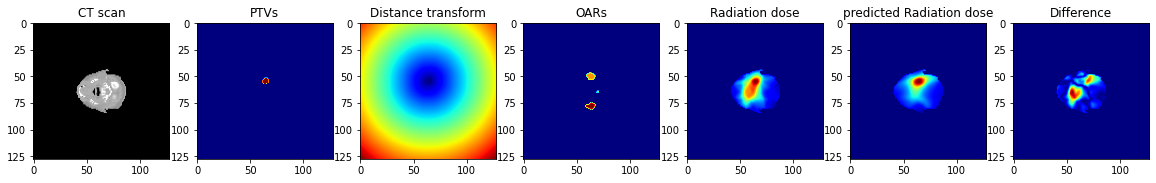

9it [00:12,  1.41s/it]

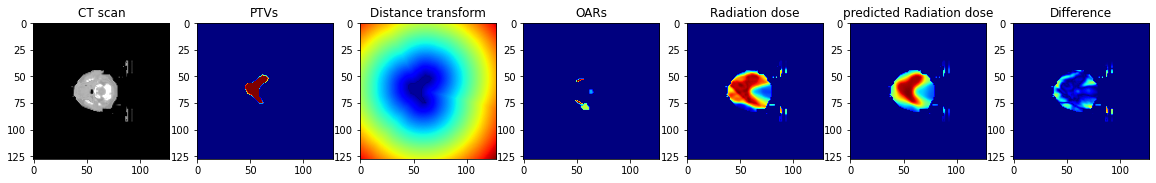

1200it [18:46,  1.06it/s]


In [13]:
from DCNN.loss import L1Loss

loss_artif = []
loss = []
Visualize = True

loss_fn= L1Loss()

for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]['data'][0]
    target = list_loader_output[0]['data'][1][0][0]
    mask = list_loader_output[0]['data'][2][0][0]
    if input_[0][0].sum()!=0:
        output = [model(input_)]# + model1(input_)[0] + model2(input_)[0])/3
        loss.append(float(loss_fn(output[0], [target, mask])))
        if batch_idx<10 and Visualize:
            show(list_loader_output[0]['data'], output[0].detach()[0]*mask)
    else:
        output = [model(input_)]# + model1(input_)[0] + model2(input_)[0])/3
        loss_artif.append(float(loss_fn(output[0], [target, mask])))
        if batch_idx<10 and Visualize:
            show(list_loader_output[0]['data'], output[0].detach()[0]*mask)
    

    
    
    

In [14]:
print(f'MAE of the predicted radiation dose in the validation set: %.3f' %np.mean(loss+loss_artif))

MAE of the predicted radiation dose in the validation set: 0.364


In [18]:
print(f'MAE of the predicted radiation dose in the validation set: %.3f' %np.mean(loss+loss_artif))

MAE of the predicted radiation dose in the validation set: 0.372


In [20]:
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

/home/infres/ahmad-21/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/infres/ahmad-21/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, 0.44050362994047726, 0.44050362994047726)

### Testing

In [18]:
mask.shape

torch.Size([128, 128])

In [19]:
loss = []
loss_fn= nn.L1Loss(reduction='mean')

for batch_idx, list_loader_output in tqdm(enumerate(test)):
    path = list_loader_output[1][0]
    input_ = list_loader_output[0][0]
    target = list_loader_output[0][1][0,0]
    mask = list_loader_output[0][2][0][0]
    if input_[0][0].sum()!=0:
        output = model(input_)
        img_pred = (output[0]*mask).detach().numpy()
    else:
        output = model(input_)
        img_pred = (output[0]*mask).detach().numpy()
    
    np.save(PATH_OUT + '/' + path.split('/')[-1], img_pred)        

1200it [18:49,  1.06it/s]
